In [2]:
from datetime import datetime
from pyquil.quil import Program
from pyquil.gates import H, RX, MEASURE, RZ, CPHASE, CNOT
from pyquil.api import get_qc
import numpy as np
from new_noise import add_noise_to_program, Calibrations
import matplotlib.pyplot as plt
from pyquil_for_azure_quantum import get_qpu

%env AZURE_QUANTUM_SUBSCRIPTION_ID=6fa0413d-054b-450c-929b-bffe17b56ad2
%env AZURE_QUANTUM_WORKSPACE_RG=AzureQuantum
%env AZURE_QUANTUM_WORKSPACE_NAME= nonlocal-new-ea
%env AZURE_QUANTUM_WORKSPACE_LOCATION=westus
%env LOG_LEVEL=DEBUG aspen M-2.ipynb

date = datetime.today().strftime('%d-%m-%y')
num=1

env: AZURE_QUANTUM_SUBSCRIPTION_ID=6fa0413d-054b-450c-929b-bffe17b56ad2
env: AZURE_QUANTUM_WORKSPACE_RG=AzureQuantum
env: AZURE_QUANTUM_WORKSPACE_NAME=nonlocal-new-ea
env: AZURE_QUANTUM_WORKSPACE_LOCATION=westus
env: LOG_LEVEL=DEBUG aspen M-2.ipynb


Adiabatic shift

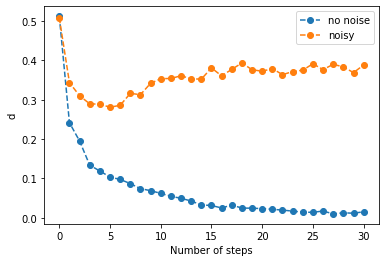

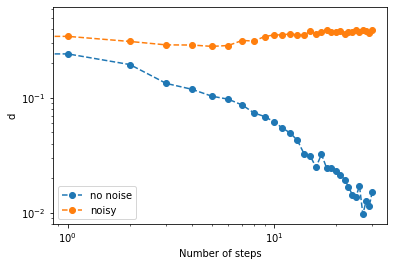

In [37]:
def adiabatic_shift(qc, qubits, steps, numshots, noise=False, cal=None):
    p = Program()
    for i in range(qubits):
        p += H(i)

    angles=(np.pi/2)*np.array(range(1,steps+1))/(steps+1)
    for theta in angles:
        alpha = -np.cos(theta)
        beta = -np.sin(theta)
        for i in range(qubits-1) :
            p += RZ(beta,i)
            p += RZ(beta,i+1)
            p += CPHASE(-2*beta,i,i+1)
        for i in range(qubits):
            p += RX(alpha, i)

    p.declare('ro', 'BIT', qubits)
    for i in range(qubits):
        p += MEASURE(i, ("ro", i))
    p.wrap_in_numshots_loop(numshots)
    if noise:
        if cal is not None:
            p = add_noise_to_program(qc, p, convert_to_native=False, calibrations=cal)
        else:
            p = add_noise_to_program(qc, p, convert_to_native=False)
    bitstrings = qc.run(p).readout_data.get("ro")
    d = 0
    for i in bitstrings:
        for q in range(qubits-1):
            d += (i[q] != i[q+1])
    d /= numshots*(qubits-1)
    return d

def plot_results(no_noise, noisy, log=False):
    plt.plot(no_noise,linestyle='--', marker='o', label='no noise')
    plt.plot(noisy,linestyle='--', marker='o', label='noisy')
    plt.xlabel('Number of steps')
    plt.ylabel('d')
    plt.legend()
    if log:
        plt.yscale('log')
        plt.xscale('log')
    plt.show()

def run_experiment(qubits, numshots, maxN):
    qc = get_qc('Aspen-M-3', as_qvm=True, execution_timeout=1000)
    cal = Calibrations(qc)
    no_noise = np.zeros(maxN)
    noisy = np.zeros(maxN)
    for i in range (maxN):
        no_noise[i] = adiabatic_shift(qc, qubits=qubits, steps=i, numshots=numshots, noise=False)
        noisy[i] = adiabatic_shift(qc, qubits=qubits, steps=i, numshots=numshots, noise=True, cal=cal)
    return no_noise, noisy

no_noise, noisy = run_experiment(8,500,31)
plot_results(no_noise, noisy)
plot_results(no_noise, noisy, log=True)

GHZ

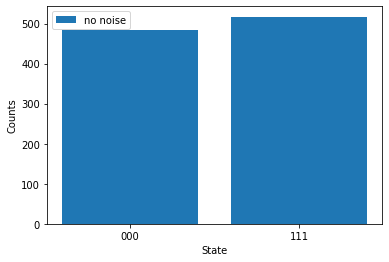

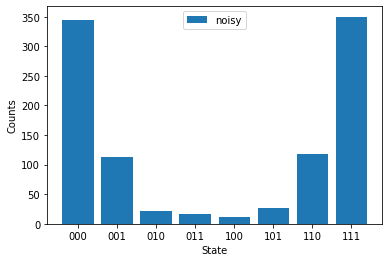

In [34]:
def ghz(qc, qubits, numshots, noise=False, cal=None):
    p = Program()
    p.declare("ro", "BIT", 3)
    p += H(qubits[0])
    p += CNOT(qubits[0], qubits[1])
    p += CNOT(qubits[1], qubits[2])
    p += MEASURE(qubits[0], ("ro", 0))
    p += MEASURE(qubits[1], ("ro", 1))
    p += MEASURE(qubits[2], ("ro", 2))
    p.wrap_in_numshots_loop(numshots)
    if noise:
        if cal is not None:
            p = add_noise_to_program(qc, p, calibrations=cal)
        else:
            p = add_noise_to_program(qc, p)
    return p

def run_experiment(qpu, qubits, numshots):
    qvm = get_qc(qpu, as_qvm=True, execution_timeout=1000)
    cal = Calibrations(qvm)
    no_noise = qvm.run(ghz(qvm,qubits,numshots, False)).readout_data.get("ro")
    noisy = qvm.run(ghz(qvm,qubits,numshots, True, cal)).readout_data.get("ro")


    qc = get_qpu(qpu)
    exe = qc.compile(ghz(qc,qubits,numshots, False), to_native_gates=True)
    real = qc.run(exe).readout_data.get("ro")
    return no_noise, noisy, real

def plot_results(results, label):
    histogram={}
    for i in results:
        code=("00"+str(int(float(i[2])*100+float(i[1])*10+float(i[0]))))[-3:]
        histogram[code]=histogram.get(code,0)+1
    histogram=dict(sorted(histogram.items()))
    plt.bar(*zip(*histogram.items()), label=label)
    plt.xlabel('State')
    plt.ylabel('Counts')
    plt.legend()
    plt.show()

no_noise, noisy, real = run_experiment('Aspen-M-2', [5,6,7], 1000)
plot_results(no_noise, 'no noise')
plot_results(noisy, 'noisy')
plot_results(real, 'real')

